In [124]:
import numpy as np
import pandas as pd
import scipy
from scipy import io
from scipy.sparse import csc_array
import matplotlib.pyplot as plt

In [ ]:
# Change this to your exact path
file_path = r'../data/aPCx_15.mat'

with open(file_path, 'rb') as f:
    # Read the first 50 bytes
    header = f.read(50)
    print(f"Header bytes: {header}")

Header bytes: b'MATLAB 5.0 MAT-file, Platform: MACI64, Created on:'


In [126]:
# Load the MAT file
mat_data = io.loadmat(file_path,squeeze_me=True,struct_as_record=False)

# Print the keys (variable names) in the MAT file
print(mat_data.keys())

# Access a specific variable
data = mat_data['espe']
#print(data[0].shank[0].SUA.cell[0].odor[0].spikeMatrix)
print(data[0].shank[0].SUA.cell[1]._fieldnames)
print(len(data))

dict_keys(['__header__', '__version__', '__globals__', 'espe'])
['odor', 'meanWaveform', 'spikeSNR', 'isolationDistance', 'L_Ratio', 'good']
10


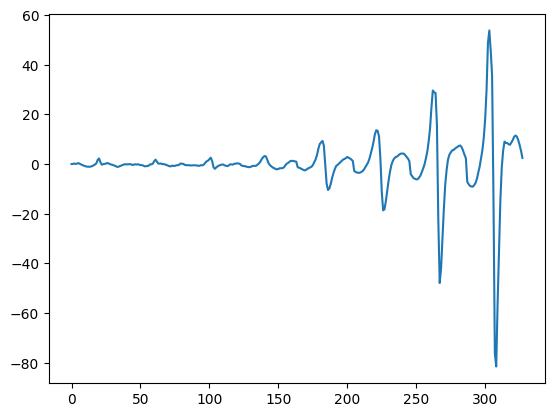

In [127]:
wave = data[0].shank[0].SUA.cell[0].meanWaveform

plt.plot(wave)

In [128]:
baseline_win = np.array([i for i in range(2000,4000)])
response_win = np.array([i for i in range(4000,10000)])

In [129]:
def get_firing_rate(data,response_win,baseline_win):

    rates = []
    for i in range(len(data)):
        spikes_trial = data.iloc[i]
        baseline_spikes = spikes_trial.iloc[baseline_win]
        response_spikes = spikes_trial.iloc[response_win]
        baseline_rate = baseline_spikes[baseline_spikes==1].sum()/(len(baseline_win)/1000)
        response_rate = response_spikes[response_spikes==1].sum()/(len(response_win)/1000)
        if baseline_rate > response_rate:
            respons_sans_base = 0.0
        else: 
            respons_sans_base = response_rate-baseline_rate
        rates.append(respons_sans_base)
    
    return np.array(rates)

In [130]:
def get_firing_rate_2(data,baseline_start=2000,resp_start=4000,baseline_duration=2,resp_duration=6):

    spikes_dict = data.todok()
    rates = []
    for trial in range(10):
    
        if trial not in set(data.indices):
            rates.append(0.0)
            continue

        dok_arr = spikes_dict[trial].todok()
        keys = np.array(list(dok_arr.keys()))
        base_keys = keys[(keys>=baseline_start) & (keys<resp_start)]
        resp_keys = keys[keys>=resp_start]
        base_spikes = []
        resp_spikes = []
        
        for key in base_keys:
            base_spikes.append(dok_arr[key])
        for key in resp_keys:
            resp_spikes.append(dok_arr[key])
        
        base_rate = np.array(base_spikes).sum()/baseline_duration
        resp_rate = np.array(resp_spikes).sum()/resp_duration

        if base_rate > resp_rate:
            rates.append(0.0)
        else:
            rates.append(resp_rate-base_rate)


    return np.array(rates)

In [131]:
def preprocess(data,response_win,baseline_win):

    sessions = []
    for session in data:
        cols = np.empty(shape=(150,0)) # n odors * n trials = 150 / need to find a better way to initialize
        for shank in session.shank:
            if type(shank.SUA)==np.ndarray: # if SUA is empty it appears as an empty np array
                continue
            if type(shank.SUA.cell)!=np.ndarray: # if there is only one cell it appears as mat_struct
                cells = np.array([shank.SUA.cell])
            else:
                cells = shank.SUA.cell
                for cell in cells:
                    rows = np.array([]) # rows per 1 neuron, should result in (150,) np array
                    for odor in cell.odor:
                        spikes = pd.DataFrame.sparse.from_spmatrix(odor.spikeMatrix) # (10,10000) Dataframe
                        rates = get_firing_rate(spikes,response_win,baseline_win) # (10,) np array
                        rows = np.concatenate((rows,rates),axis=0)
                    
                    rows = rows[:,np.newaxis] # converts rows to (150,1) shape
                    cols = np.concatenate((cols,rows),axis=1)

        sessions.append(cols)     
        print('Session appended')  

    return sessions

In [134]:
def preprocess_2(data,baseline_start=2000,resp_start=4000,baseline_duration=2,resp_duration=6):

    sessions = []
    for session in data:
        cols = np.empty(shape=(150,0)) # n odors * n trials = 150 / need to find a better way to initialize
        for shank in session.shank:
            if type(shank.SUA)==np.ndarray: # if SUA is empty it appears as an empty np array
                continue
            if type(shank.SUA.cell)!=np.ndarray: # if there is only one cell it appears as mat_struct
                cells = np.array([shank.SUA.cell])
            else:
                cells = shank.SUA.cell
                for cell in cells:
                    rows = np.array([]) # rows per 1 neuron, should result in (150,) np array
                    for odor in cell.odor:
                        spikes = odor.spikeMatrix # scipy.sparse._csc.csc_array
                        rates = get_firing_rate_2(spikes,baseline_start,resp_start,baseline_duration,resp_duration) # (10,) np array
                        rows = np.concatenate((rows,rates),axis=0)
                    
                    rows = rows[:,np.newaxis] # converts rows to (150,1) shape
                    cols = np.concatenate((cols,rows),axis=1)

        sessions.append(cols)     
        print('Session appended')  

    return sessions

In [135]:
sessions = preprocess_2(data)

Session appended
Session appended
Session appended
Session appended
Session appended
Session appended
Session appended
Session appended
Session appended
Session appended


In [136]:
sessions[0].shape

(150, 20)

In [137]:
sessions[0][0,:]

array([0.        , 0.        , 0.66666667, 2.5       , 0.5       ,
       0.        , 0.16666667, 0.66666667, 0.        , 1.33333333,
       0.16666667, 0.        , 0.66666667, 0.        , 3.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ])

In [ ]:
c = 1
for session in sessions:
    np.save(file=f'../processed_data/aPCx_15/session_{c}.npy',arr=session)
    c += 1

In [117]:
spikes = data[0].shank[0].SUA.cell[0].odor[0].spikeMatrix

In [36]:
print(spikes)

<Compressed Sparse Column sparse array of dtype 'uint8'
	with 116 stored elements and shape (10, 10000)>
  Coords	Values
  (9, 144)	1
  (1, 366)	1
  (4, 501)	1
  (5, 690)	1
  (4, 726)	1
  (9, 758)	1
  (4, 823)	1
  (4, 924)	1
  (8, 1206)	1
  (9, 1291)	1
  (9, 1297)	1
  (2, 1419)	1
  (4, 1431)	1
  (4, 1438)	1
  (4, 1575)	1
  (4, 1649)	1
  (0, 1976)	1
  (9, 2014)	1
  (9, 2021)	1
  (9, 2025)	1
  (9, 2185)	1
  (4, 2666)	1
  (0, 2757)	1
  (9, 3113)	1
  (9, 3119)	1
  :	:
  (5, 7793)	1
  (3, 7826)	1
  (9, 7984)	1
  (9, 8204)	1
  (4, 8267)	1
  (7, 8309)	1
  (7, 8314)	1
  (7, 8321)	1
  (0, 8623)	1
  (3, 8678)	1
  (5, 8766)	1
  (3, 9039)	1
  (3, 9045)	1
  (9, 9102)	1
  (6, 9238)	1
  (6, 9247)	1
  (9, 9370)	1
  (9, 9443)	1
  (9, 9452)	1
  (6, 9469)	1
  (6, 9478)	1
  (6, 9484)	1
  (9, 9590)	1
  (5, 9655)	1
  (5, 9668)	1


In [11]:
type(spikes)

scipy.sparse._csc.csc_array

In [123]:
spikes = data[0].shank[0].SUA.cell[0].odor[3].spikeMatrix
rates = get_firing_rate_2(spikes)
rates

array([1.5       , 0.        , 3.16666667, 4.16666667, 1.        ,
       1.33333333, 2.66666667, 2.5       , 0.5       , 3.33333333])

In [86]:
baseline_start, resp_start = 2000, 4000
baseline_duration, resp_duration = 2, 6 # sec
spikes_dict = spikes.todok()
for trial in set(spikes.indices):
    dok_arr = spikes_dict[trial].todok()
    keys = np.array(list(dok_arr.keys()))
    base_keys = keys[(keys>=baseline_start) & (keys<resp_start)]
    resp_keys = keys[keys>=resp_start]
    base_spikes = []
    resp_spikes = []
    for key in base_keys:
        base_spikes.append(dok_arr[key])
    for key in resp_keys:
        resp_spikes.append(dok_arr[key])
    base_rate = np.array(base_spikes).sum()/baseline_duration
    resp_rate = np.array(resp_spikes).sum()/resp_duration
    print(f'Trial: {trial}\nResponse minus baseline: {resp_rate-base_rate}')

Trial: 0
Response minus baseline: -0.8333333333333334
Trial: 1
Response minus baseline: 0.0
Trial: 2
Response minus baseline: -1.3333333333333333
Trial: 3
Response minus baseline: 3.1666666666666665
Trial: 4
Response minus baseline: -0.33333333333333337
Trial: 5
Response minus baseline: 2.5
Trial: 6
Response minus baseline: 0.5
Trial: 7
Response minus baseline: 1.3333333333333333
Trial: 8
Response minus baseline: 0.0
Trial: 9
Response minus baseline: -2.5


In [66]:
trials = spikes.indices
trials = set(trials)
trials

{np.int32(0),
 np.int32(1),
 np.int32(2),
 np.int32(3),
 np.int32(4),
 np.int32(5),
 np.int32(6),
 np.int32(7),
 np.int32(8),
 np.int32(9)}

In [18]:
attributes = ['dtype', 'shape', 'ndim', 'nnz', 'size', 'data', 'indices', 'indptr', 'has_sorted_indices', 'has_canonical_format']

for attr in attributes:
    print(f'{attr}: {getattr(spikes,attr)}')

dtype: uint8
shape: (10, 10000)
ndim: 2
nnz: 116
size: 116
data: [1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1]
indices: [9 1 4 5 4 9 4 4 8 9 9 2 4 4 4 4 0 9 9 9 9 4 0 9 9 9 6 2 2 2 6 0 9 9 9 9 9
 9 3 3 9 9 3 3 3 9 9 9 9 9 9 3 5 5 9 9 6 9 3 3 3 3 3 2 9 6 5 5 5 5 3 7 7 3
 3 3 7 9 6 5 5 5 5 7 9 7 9 5 9 6 9 5 3 9 9 4 7 7 7 0 3 5 3 3 9 6 6 9 9 9 6
 6 6 9 5 5]
indptr: [  0   0   0 ... 116 116 116]
has_sorted_indices: True
has_canonical_format: True


In [37]:
spikes_dict = csc_array.todok(spikes)

In [39]:
print(spikes_dict)
print(spikes_dict[0])

<Dictionary Of Keys sparse array of dtype 'uint8'
	with 116 stored elements and shape (10, 10000)>
  Coords	Values
  (0, 1976)	1
  (0, 2757)	1
  (0, 3517)	1
  (0, 8623)	1
  (1, 366)	1
  (2, 1419)	1
  (2, 3403)	1
  (2, 3408)	1
  (2, 3422)	1
  (2, 6363)	1
  (3, 4155)	1
  (3, 4159)	1
  (3, 5105)	1
  (3, 5111)	1
  (3, 5115)	1
  (3, 5819)	1
  (3, 6331)	1
  (3, 6335)	1
  (3, 6340)	1
  (3, 6345)	1
  (3, 6349)	1
  (3, 6523)	1
  (3, 6571)	1
  (3, 6576)	1
  (3, 6581)	1
  :	:
  (9, 3827)	1
  (9, 4200)	1
  (9, 4259)	1
  (9, 5286)	1
  (9, 5628)	1
  (9, 5644)	1
  (9, 5648)	1
  (9, 5804)	1
  (9, 5815)	1
  (9, 5949)	1
  (9, 5955)	1
  (9, 6238)	1
  (9, 6375)	1
  (9, 6972)	1
  (9, 7134)	1
  (9, 7404)	1
  (9, 7463)	1
  (9, 7645)	1
  (9, 7984)	1
  (9, 8204)	1
  (9, 9102)	1
  (9, 9370)	1
  (9, 9443)	1
  (9, 9452)	1
  (9, 9590)	1
<COOrdinate sparse array of dtype 'uint8'
	with 4 stored elements and shape (10000,)>
  Coords	Values
  (1976,)	1
  (2757,)	1
  (3517,)	1
  (8623,)	1


In [43]:
print(spikes_dict[0])

<COOrdinate sparse array of dtype 'uint8'
	with 4 stored elements and shape (10000,)>
  Coords	Values
  (1976,)	1
  (2757,)	1
  (3517,)	1
  (8623,)	1


In [80]:
# Convert to Dictionary of Keys format
dok_arr = spikes_dict[0].todok()
print(dok_arr.keys())
keys = np.array(list(dok_arr.keys()))
print(keys)
print(keys[keys>=2000])

# Iterate like a standard dictionary
#for (index,), value in dok_arr.items():
    #print(f"At index {index}: {value}")

dict_keys([np.int32(1976), np.int32(2757), np.int32(3517), np.int32(8623)])
[1976 2757 3517 8623]
[2757 3517 8623]


In [28]:
csc_array.sort_indices(spikes)

In [29]:
print(spikes)

<Compressed Sparse Column sparse array of dtype 'uint8'
	with 116 stored elements and shape (10, 10000)>
  Coords	Values
  (9, 144)	1
  (1, 366)	1
  (4, 501)	1
  (5, 690)	1
  (4, 726)	1
  (9, 758)	1
  (4, 823)	1
  (4, 924)	1
  (8, 1206)	1
  (9, 1291)	1
  (9, 1297)	1
  (2, 1419)	1
  (4, 1431)	1
  (4, 1438)	1
  (4, 1575)	1
  (4, 1649)	1
  (0, 1976)	1
  (9, 2014)	1
  (9, 2021)	1
  (9, 2025)	1
  (9, 2185)	1
  (4, 2666)	1
  (0, 2757)	1
  (9, 3113)	1
  (9, 3119)	1
  :	:
  (5, 7793)	1
  (3, 7826)	1
  (9, 7984)	1
  (9, 8204)	1
  (4, 8267)	1
  (7, 8309)	1
  (7, 8314)	1
  (7, 8321)	1
  (0, 8623)	1
  (3, 8678)	1
  (5, 8766)	1
  (3, 9039)	1
  (3, 9045)	1
  (9, 9102)	1
  (6, 9238)	1
  (6, 9247)	1
  (9, 9370)	1
  (9, 9443)	1
  (9, 9452)	1
  (6, 9469)	1
  (6, 9478)	1
  (6, 9484)	1
  (9, 9590)	1
  (5, 9655)	1
  (5, 9668)	1


In [21]:
sorted_spikes = csc_array.sorted_indices(spikes)

In [23]:
print(sorted_spikes)

<Compressed Sparse Column sparse array of dtype 'uint8'
	with 116 stored elements and shape (10, 10000)>
  Coords	Values
  (9, 144)	1
  (1, 366)	1
  (4, 501)	1
  (5, 690)	1
  (4, 726)	1
  (9, 758)	1
  (4, 823)	1
  (4, 924)	1
  (8, 1206)	1
  (9, 1291)	1
  (9, 1297)	1
  (2, 1419)	1
  (4, 1431)	1
  (4, 1438)	1
  (4, 1575)	1
  (4, 1649)	1
  (0, 1976)	1
  (9, 2014)	1
  (9, 2021)	1
  (9, 2025)	1
  (9, 2185)	1
  (4, 2666)	1
  (0, 2757)	1
  (9, 3113)	1
  (9, 3119)	1
  :	:
  (5, 7793)	1
  (3, 7826)	1
  (9, 7984)	1
  (9, 8204)	1
  (4, 8267)	1
  (7, 8309)	1
  (7, 8314)	1
  (7, 8321)	1
  (0, 8623)	1
  (3, 8678)	1
  (5, 8766)	1
  (3, 9039)	1
  (3, 9045)	1
  (9, 9102)	1
  (6, 9238)	1
  (6, 9247)	1
  (9, 9370)	1
  (9, 9443)	1
  (9, 9452)	1
  (6, 9469)	1
  (6, 9478)	1
  (6, 9484)	1
  (9, 9590)	1
  (5, 9655)	1
  (5, 9668)	1


In [23]:
spikes_full = pd.DataFrame.sparse.from_spmatrix(spikes)

In [24]:
spikes_full

,0,1,2,3,4,5,6,7,8,9,...,9990,9991,9992,9993,9994,9995,9996,9997,9998,9999
0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
5,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
6,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
7,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
8,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
9,0,0,0,0,0,0,0,1,0,0,...,0,0,0,0,0,0,0,0,0,0


In [77]:
baseline_win = np.array([i for i in range(2000,4000)])
response_win = np.array([i for i in range(4000,10000)])
print(len(baseline_win),len(response_win))
rates = []
for i in range(len(spikes_full)):
    spikes_trial = spikes_full.iloc[i]
    baseline_spikes = spikes_trial.iloc[baseline_win]
    response_spikes = spikes_trial.iloc[response_win]
    baseline_rate = baseline_spikes[baseline_spikes==1].sum()/(len(baseline_win)/1000)
    response_rate = response_spikes[response_spikes==1].sum()/(len(response_win)/1000)
    if baseline_rate > response_rate:
        respons_sans_base = 0.0
    else: 
        respons_sans_base = response_rate-baseline_rate
    rates.append(respons_sans_base)
    #print(f'Trial: {i}\nResponse: {response_rate:.2f} Hz\nBaseline substracted response rate: {respons_sans_base:.2f} Hz')
rates = np.array(rates)
print(rates.shape)

2000 6000
(10,)


In [68]:
arr = np.array([])
print(arr)
arr = np.concatenate((arr,rates),axis=0)
print(arr.shape)

[]
(10,)


In [78]:
arr = np.empty(shape=(10,0))
print(arr.shape)

rates = rates[:,np.newaxis]
print(rates.shape)
arr = np.concatenate((arr,rates),axis=1)
print(arr)
arr = np.concatenate((arr,rates),axis=1)
print(arr)

(10, 0)
(10, 1)
[[1.16666667]
 [0.83333333]
 [0.        ]
 [0.16666667]
 [0.        ]
 [0.        ]
 [0.        ]
 [0.        ]
 [0.        ]
 [0.16666667]]
[[1.16666667 1.16666667]
 [0.83333333 0.83333333]
 [0.         0.        ]
 [0.16666667 0.16666667]
 [0.         0.        ]
 [0.         0.        ]
 [0.         0.        ]
 [0.         0.        ]
 [0.         0.        ]
 [0.16666667 0.16666667]]


In [ ]:
spikes_trial_1 = spikes_full.iloc[1]

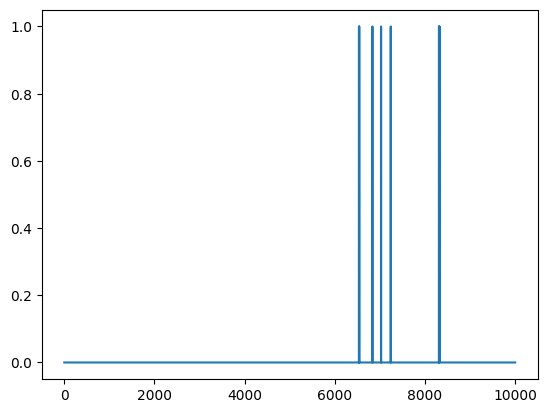

In [81]:
plt.plot(spikes_trial_1)

(3380.0, 3440.0)

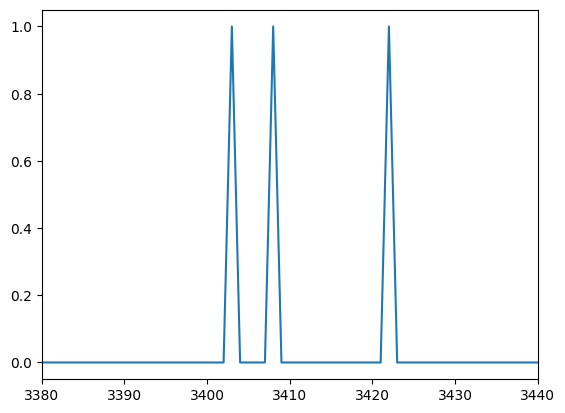

In [67]:
plt.plot(spikes_trial_1)
plt.xlim(3380,3440)

In [ ]:
file_path = r'../data/plCoA_15.mat'
# Load the MAT file
mat_data = io.loadmat(file_path,squeeze_me=True,struct_as_record=False)

# Print the keys (variable names) in the MAT file
print(mat_data.keys())

# Access a specific variable
data = mat_data['espe']
#print(data[0].shank[0].SUA.cell[0].odor[0].spikeMatrix)
print(data[0].shank[0].SUA.cell[1]._fieldnames)
print(data[1].shank[2].SUA.cell)
print(type(data[1].shank[2].SUA.cell))
#print(type(data[1].shank[2].SUA)==np.ndarray)
#print(len(data[1].shank[0].SUA.cell))
#for session in data:
    ##for shank in session.shank:
        #print(shank)

dict_keys(['__header__', '__version__', '__globals__', 'espe'])
['odor', 'meanWaveform', 'spikeSNR', 'isolationDistance', 'L_Ratio', 'good']
<class 'numpy.ndarray'>
